# Stage 3: Model Evaluation & Analysis

**Objectives**:
- Load the trained model
- Evaluate on test set
- Generate comprehensive metrics and visualizations
- Test on external dataset
- Analyze model performance and errors

**Output**: Comprehensive evaluation metrics and visualizations for the final report

## 1. Import Libraries

In [1]:
# Add parent directory to path for imports
import sys
from pathlib import Path
sys.path.append(str(Path('..').resolve()))
import fastai
from fastai.vision.all import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from utils import set_seed as set_all_seeds

# Set seed for reproducibility
set_all_seeds(42)

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')

print(f"PyTorch version: {torch.__version__}")
print(f"fastai version: {fastai.__version__}")

✓ Random seed set to 42 for reproducibility
PyTorch version: 2.9.1
fastai version: 2.8.5


## 2. Load Model and Data

In [2]:
# Load trained model
model_path = '../outputs/model.pkl'
learn = load_learner(model_path)

print(f"✓ Model loaded from: {model_path}")
print(f"  Classes: {learn.dls.vocab}")
print(f"  Number of classes: {len(learn.dls.vocab)}")

✓ Model loaded from: ../outputs/model.pkl
  Classes: ['basophil', 'eosinophil', 'lymphocyte', 'monocyte', 'neutrophil']
  Number of classes: 5


/Users/mac/miniconda3/envs/cv/lib/python3.11/site-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [3]:
# Load data split
split_df = pd.read_csv('../outputs/data_split.csv')

# Get test set
test_df = split_df[split_df['split'] == 'test'].reset_index(drop=True)

print(f"Test set size: {len(test_df)}")
print(f"\nClass distribution in test set:")
print(test_df['label'].value_counts().sort_index())

Test set size: 375

Class distribution in test set:
label
basophil      75
eosinophil    75
lymphocyte    75
monocyte      75
neutrophil    75
Name: count, dtype: int64


## 3. Evaluate on Test Set

In [4]:
# Create test dataloader (without labels - we'll map them manually)
# test_df['filepath'] = '../' + test_df['filepath']
test_dl = learn.dls.test_dl(test_df['filepath'].tolist())

# Get predictions
print("Generating predictions on test set...")
preds = learn.get_preds(dl=test_dl)[0]

# Convert to class predictions
pred_classes = preds.argmax(dim=1)

# Get true labels manually from dataframe
true_labels = torch.tensor([learn.dls.vocab.o2i[label] for label in test_df['label']])

# Calculate accuracy
test_accuracy = (pred_classes == true_labels).float().mean()

print(f"Test Set Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Store targets for later use (to match variable names in other cells)
targets = true_labels

Generating predictions on test set...


Test Set Accuracy: 0.9840 (98.40%)


## 4. Confusion Matrix

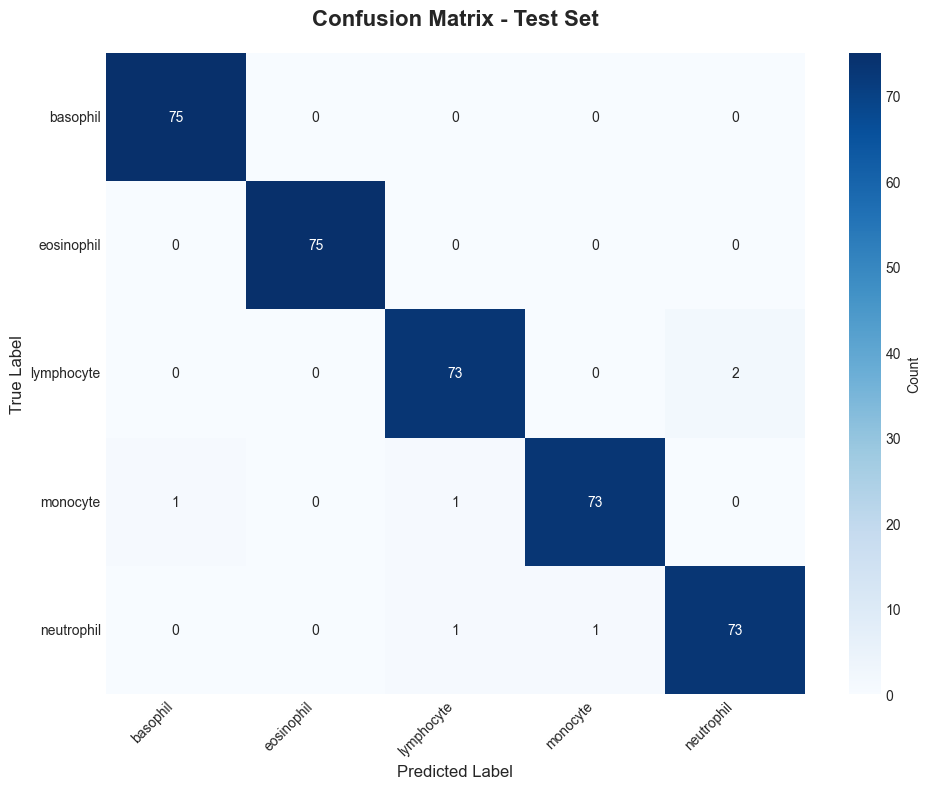

✓ Confusion matrix saved


In [5]:
# Generate confusion matrix
cm = confusion_matrix(targets.numpy(), pred_classes.numpy())
class_names = learn.dls.vocab

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Test Set', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('../outputs/figures/confusion_matrix_test.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Confusion matrix saved")

## 5. Classification Report

In [6]:
# Generate detailed classification report
report = classification_report(
    targets.numpy(), 
    pred_classes.numpy(), 
    target_names=class_names,
    digits=4
)

print("Classification Report - Test Set")
print("="*70)
print(report)

Classification Report - Test Set
              precision    recall  f1-score   support

    basophil     0.9868    1.0000    0.9934        75
  eosinophil     1.0000    1.0000    1.0000        75
  lymphocyte     0.9733    0.9733    0.9733        75
    monocyte     0.9865    0.9733    0.9799        75
  neutrophil     0.9733    0.9733    0.9733        75

    accuracy                         0.9840       375
   macro avg     0.9840    0.9840    0.9840       375
weighted avg     0.9840    0.9840    0.9840       375



In [8]:
# Create per-class metrics dataframe
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(
    targets.numpy(), 
    pred_classes.numpy()
)

metrics_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

# Calculate accuracy per class
per_class_acc = []
for i, class_name in enumerate(class_names):
    class_mask = targets == i
    class_correct = (pred_classes[class_mask] == targets[class_mask]).sum()
    class_total = class_mask.sum()
    acc = class_correct / class_total if class_total > 0 else 0
    per_class_acc.append(acc.item())

metrics_df['Accuracy'] = per_class_acc

print("\nPer-Class Metrics:")
print(metrics_df.to_string(index=False))


Per-Class Metrics:
     Class  Precision   Recall  F1-Score  Support  Accuracy
  basophil   0.986842 1.000000  0.993377       75  1.000000
eosinophil   1.000000 1.000000  1.000000       75  1.000000
lymphocyte   0.973333 0.973333  0.973333       75  0.973333
  monocyte   0.986486 0.973333  0.979866       75  0.973333
neutrophil   0.973333 0.973333  0.973333       75  0.973333


/var/folders/wg/l913cp994dgc0lk1jcm9l7w40000gn/T/ipykernel_3945/1165454668.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(class_names, rotation=45, ha='right')


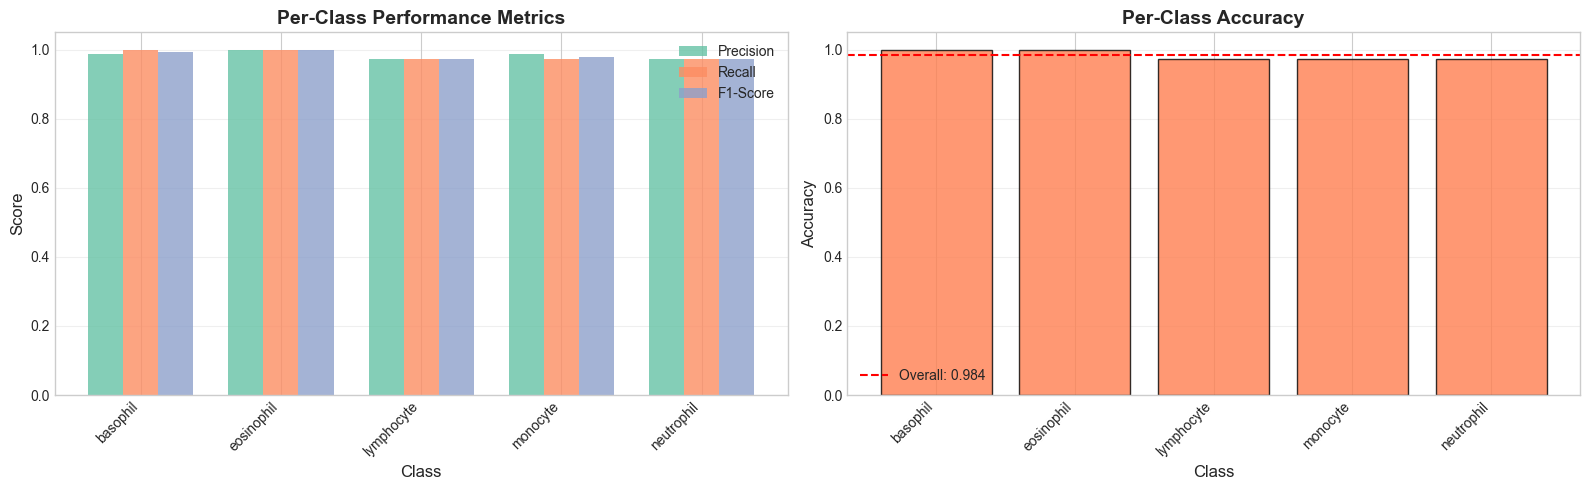

In [9]:
# Visualize per-class performance
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: Precision, Recall, F1-Score
x = np.arange(len(class_names))
width = 0.25

axes[0].bar(x - width, metrics_df['Precision'], width, label='Precision', alpha=0.8)
axes[0].bar(x, metrics_df['Recall'], width, label='Recall', alpha=0.8)
axes[0].bar(x + width, metrics_df['F1-Score'], width, label='F1-Score', alpha=0.8)
axes[0].set_xlabel('Class', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Per-Class Performance Metrics', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(class_names, rotation=45, ha='right')
axes[0].legend()
axes[0].set_ylim([0, 1.05])
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: Accuracy per class
axes[1].bar(class_names, metrics_df['Accuracy'], color='coral', alpha=0.8, edgecolor='black')
axes[1].set_xlabel('Class', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Per-Class Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xticklabels(class_names, rotation=45, ha='right')
axes[1].set_ylim([0, 1.05])
axes[1].axhline(y=test_accuracy.item(), color='r', linestyle='--', label=f'Overall: {test_accuracy:.3f}')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/per_class_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Error Analysis

In [10]:
# Find misclassified examples
misclassified_idx = (pred_classes != targets).nonzero(as_tuple=True)[0]

print(f"Misclassified samples: {len(misclassified_idx)} out of {len(test_df)}")
print(f"Error rate: {len(misclassified_idx)/len(test_df)*100:.2f}%")

Misclassified samples: 6 out of 375
Error rate: 1.60%


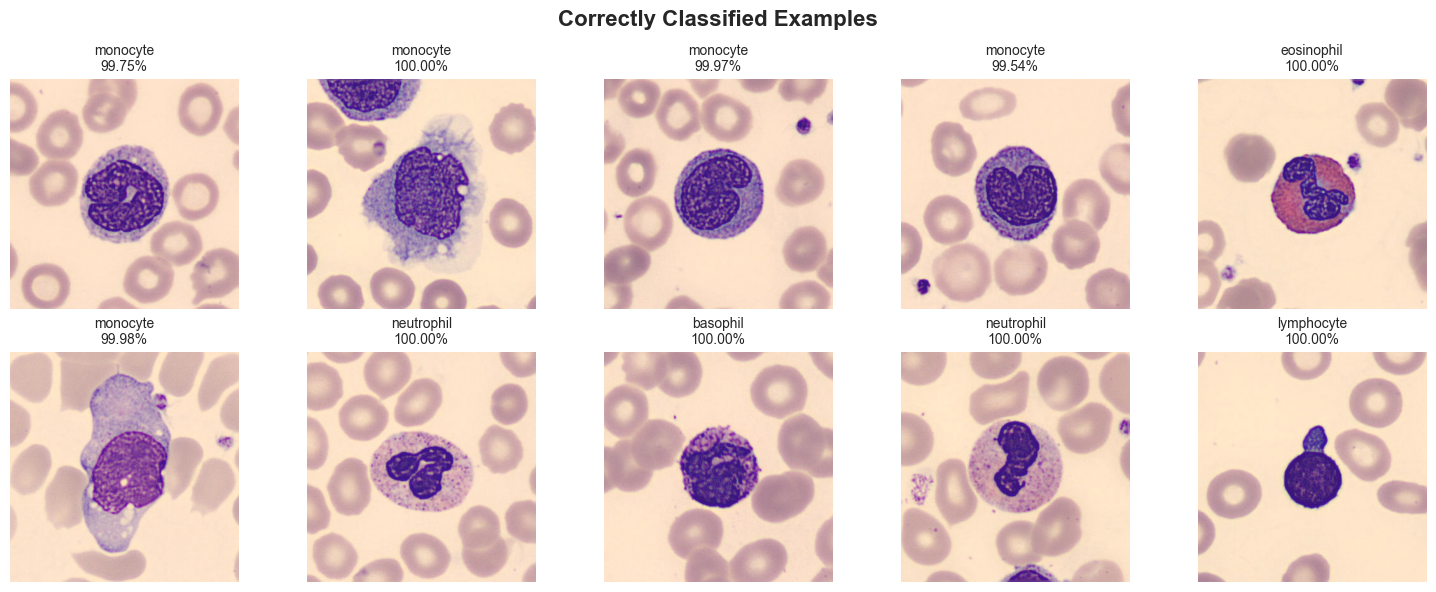

In [11]:
# Visualize some correctly classified examples
correct_idx = (pred_classes == targets).nonzero(as_tuple=True)[0]

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Correctly Classified Examples', fontsize=16, fontweight='bold')

# Sample 10 correct predictions (with seed for reproducibility)
np.random.seed(42)
sample_correct = np.random.choice(correct_idx.numpy(), size=min(10, len(correct_idx)), replace=False)

for idx, ax_idx in enumerate(sample_correct):
    # Convert numpy int to Python int
    ax_idx = int(ax_idx)
    
    img_path = test_df.iloc[ax_idx]['filepath']
    true_label = class_names[targets[ax_idx]]
    pred_label = class_names[pred_classes[ax_idx]]
    confidence = preds[ax_idx].max().item()
    
    img = Image.open(img_path)
    
    row = idx // 5
    col = idx % 5
    axes[row, col].imshow(img)
    axes[row, col].set_title(f'{true_label}\n{confidence:.2%}', fontsize=10)
    axes[row, col].axis('off')

plt.tight_layout()
plt.savefig('../outputs/figures/correct_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

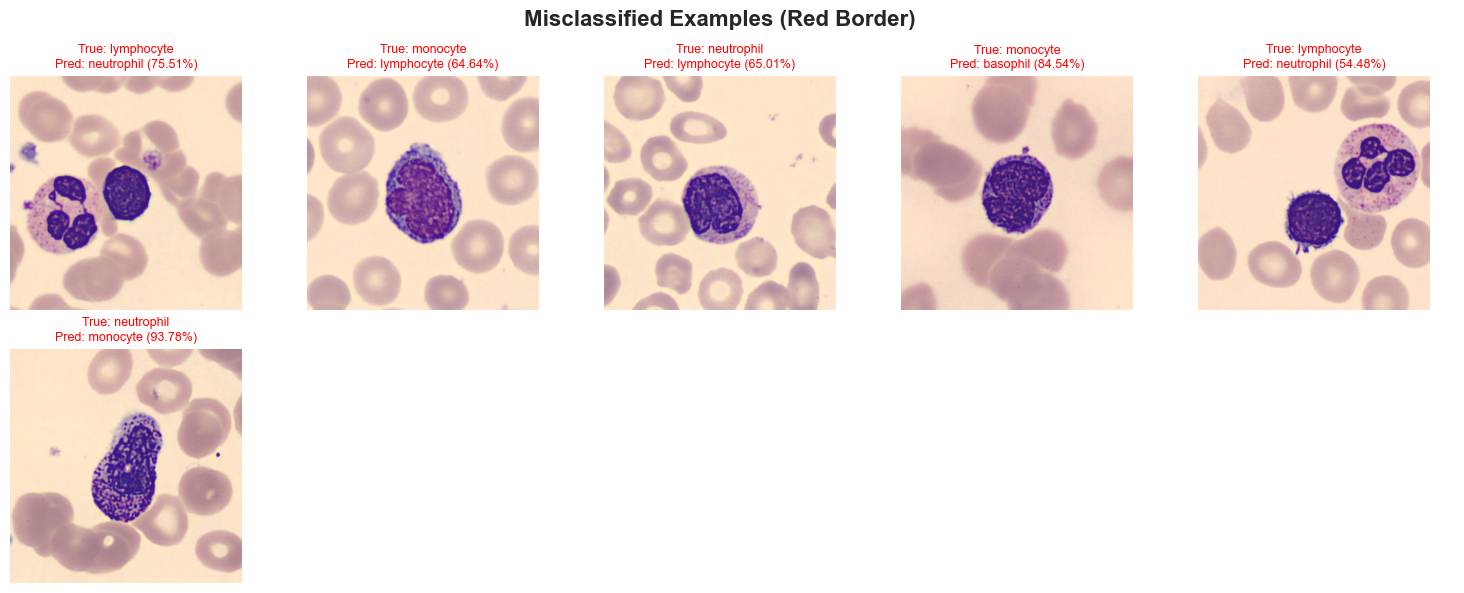

In [12]:
# Visualize misclassified examples
if len(misclassified_idx) > 0:
    n_show = min(10, len(misclassified_idx))
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle('Misclassified Examples (Red Border)', fontsize=16, fontweight='bold')
    
    # Convert tensor indices to list of integers
    sample_wrong = misclassified_idx[:n_show].tolist()
    
    for idx, ax_idx in enumerate(sample_wrong):
        img_path = test_df.iloc[ax_idx]['filepath']
        true_label = class_names[targets[ax_idx]]
        pred_label = class_names[pred_classes[ax_idx]]
        confidence = preds[ax_idx].max().item()
        
        img = Image.open(img_path)
        
        row = idx // 5
        col = idx % 5
        axes[row, col].imshow(img)
        axes[row, col].set_title(f'True: {true_label}\nPred: {pred_label} ({confidence:.2%})', 
                                 fontsize=9, color='red')
        axes[row, col].axis('off')
        for spine in axes[row, col].spines.values():
            spine.set_edgecolor('red')
            spine.set_linewidth(3)
    
    # Hide empty subplots
    for idx in range(n_show, 10):
        row = idx // 5
        col = idx % 5
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.savefig('../outputs/figures/incorrect_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No misclassifications! Perfect test accuracy!")

## 7. External Dataset Evaluation

In [13]:
# Load external dataset
external_path = Path('../Dataset and Notebook-20251115/test_second_dataset')

if external_path.exists():
    # Create dataframe for external dataset (sorted for reproducibility)
    external_data = []
    
    for class_dir in sorted(external_path.iterdir()):
        if class_dir.is_dir():
            for img_file in sorted(class_dir.glob('*.jpg')):
                external_data.append({
                    'filepath': str(img_file),
                    'filename': img_file.name,
                    'label': class_dir.name
                })
    
    external_df = pd.DataFrame(external_data)
    
    print(f"External dataset size: {len(external_df)}")
    print(f"\nClass distribution:")
    print(external_df['label'].value_counts().sort_index())
else:
    print("External dataset not found!")
    external_df = None

External dataset size: 9

Class distribution:
label
monocyte    9
Name: count, dtype: int64


Generating predictions on external dataset...


EXTERNAL DATASET EVALUATION
External Dataset Accuracy: 0.7778 (77.78%)
Classes present: ['monocyte']


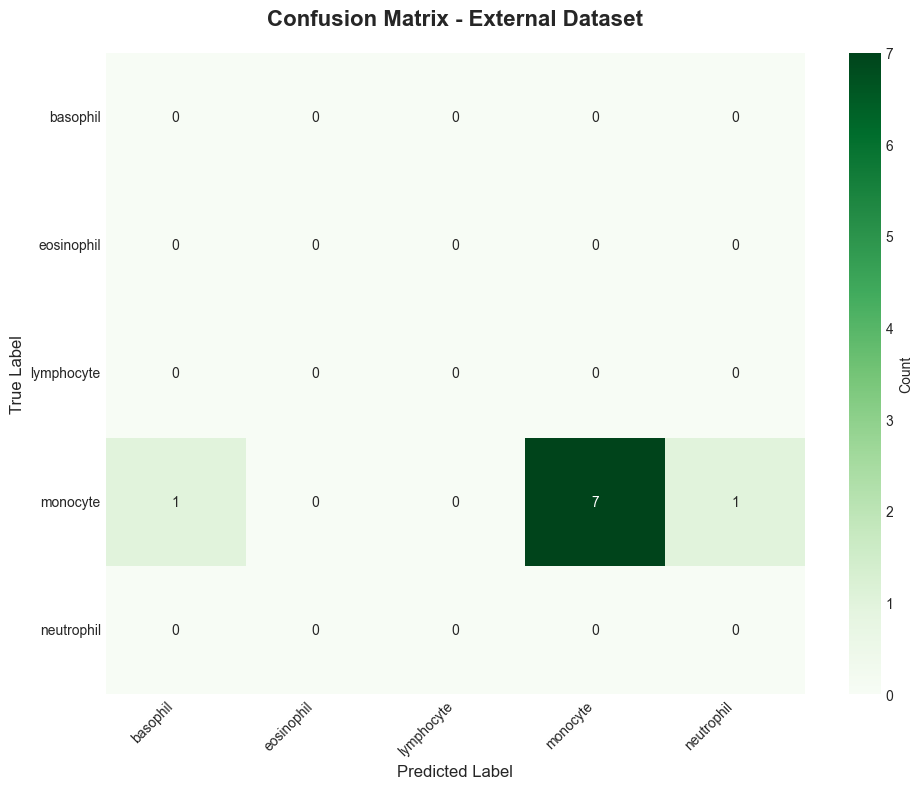


Classification Report - External Dataset
              precision    recall  f1-score   support

    basophil     0.0000    0.0000    0.0000         0
  eosinophil     0.0000    0.0000    0.0000         0
  lymphocyte     0.0000    0.0000    0.0000         0
    monocyte     1.0000    0.7778    0.8750         9
  neutrophil     0.0000    0.0000    0.0000         0

    accuracy                         0.7778         9
   macro avg     0.2000    0.1556    0.1750         9
weighted avg     1.0000    0.7778    0.8750         9


Note: External dataset may not contain all classes.
Classes present in external data: ['monocyte']


In [14]:
# Evaluate on external dataset
if external_df is not None and len(external_df) > 0:
    # Create test dataloader (without labels - we'll map them manually)
    external_dl = learn.dls.test_dl(external_df['filepath'].tolist())
    
    # Get predictions
    print("Generating predictions on external dataset...")
    ext_preds = learn.get_preds(dl=external_dl)[0]
    
    # Convert to class predictions
    ext_pred_classes = ext_preds.argmax(dim=1)
    
    # Map string labels to indices manually
    label_to_idx = {label: idx for idx, label in enumerate(class_names)}
    ext_targets_mapped = torch.tensor([label_to_idx[label.lower()] for label in external_df['label']])
    
    # Calculate accuracy
    external_accuracy = (ext_pred_classes == ext_targets_mapped).float().mean()
    
    print("="*70)
    print("EXTERNAL DATASET EVALUATION")
    print("="*70)
    print(f"External Dataset Accuracy: {external_accuracy:.4f} ({external_accuracy*100:.2f}%)")
    print(f"Classes present: {external_df['label'].unique()}")
    print("="*70)
    
    # Generate confusion matrix for external dataset
    # Use all class labels for consistency, even if some classes have 0 samples
    ext_cm = confusion_matrix(ext_targets_mapped.numpy(), ext_pred_classes.numpy(), 
                              labels=range(len(class_names)))
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(ext_cm, annot=True, fmt='d', cmap='Greens', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title('Confusion Matrix - External Dataset', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('../outputs/figures/confusion_matrix_external.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Classification report for external dataset
    # Specify labels parameter to handle missing classes
    ext_report = classification_report(
        ext_targets_mapped.numpy(), 
        ext_pred_classes.numpy(), 
        labels=range(len(class_names)),  # Include all classes
        target_names=class_names,
        digits=4,
        zero_division=0  # Handle classes with no samples
    )
    print("\nClassification Report - External Dataset")
    print("="*70)
    print(ext_report)
    print("\nNote: External dataset may not contain all classes.")
    print(f"Classes present in external data: {sorted(external_df['label'].unique())}")
else:
    print("⚠ External dataset not available - skipping external evaluation")
    external_accuracy = None

## 8. Comparison: Test vs External


Performance Comparison:
         Dataset  Accuracy  Error Rate  Size
        Test Set  0.984000    0.016000   375
External Dataset  0.777778    0.222222     9


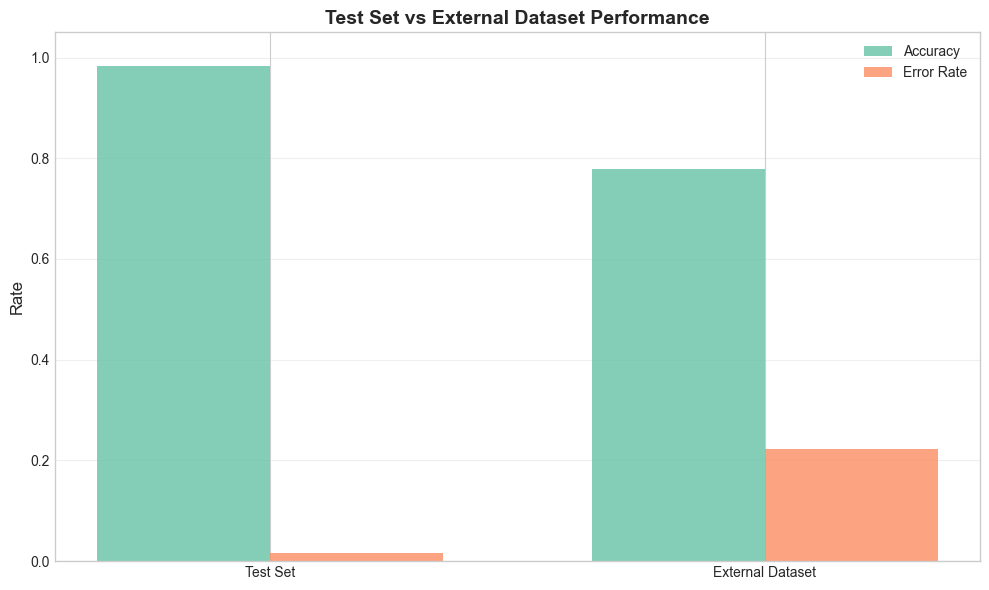

In [15]:
# Compare performance
if external_df is not None:
    comparison_data = {
        'Dataset': ['Test Set', 'External Dataset'],
        'Accuracy': [test_accuracy.item(), external_accuracy.item()],
        'Error Rate': [1 - test_accuracy.item(), 1 - external_accuracy.item()],
        'Size': [len(test_df), len(external_df)]
    }
    
    comparison_df = pd.DataFrame(comparison_data)
    
    print("\nPerformance Comparison:")
    print(comparison_df.to_string(index=False))
    
    # Visualize comparison
    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(len(comparison_df))
    width = 0.35
    
    ax.bar(x - width/2, comparison_df['Accuracy'], width, label='Accuracy', alpha=0.8)
    ax.bar(x + width/2, comparison_df['Error Rate'], width, label='Error Rate', alpha=0.8)
    
    ax.set_ylabel('Rate', fontsize=12)
    ax.set_title('Test Set vs External Dataset Performance', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(comparison_df['Dataset'])
    ax.legend()
    ax.set_ylim([0, 1.05])
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../outputs/figures/test_vs_external.png', dpi=300, bbox_inches='tight')
    plt.show()

## 9. Final Summary

In [16]:
print("="*70)
print("FINAL EVALUATION SUMMARY")
print("="*70)
print(f"\nModel: {model_path}")
print(f"Number of classes: {len(class_names)}")
print(f"Classes: {class_names}")
print(f"\nTest Set Performance:")
print(f"  Size: {len(test_df)} images")
print(f"  Accuracy: {test_accuracy*100:.2f}%")
print(f"  Error Rate: {(1-test_accuracy)*100:.2f}%")

if external_df is not None:
    print(f"\nExternal Dataset Performance:")
    print(f"  Size: {len(external_df)} images")
    print(f"  Accuracy: {external_accuracy*100:.2f}%")
    print(f"  Error Rate: {(1-external_accuracy)*100:.2f}%")
    
    accuracy_diff = abs(test_accuracy.item() - external_accuracy.item())
    print(f"\nGeneralization Gap: {accuracy_diff*100:.2f}%")
    
    if external_accuracy >= 0.92:
        print(f"\n✓ TARGET ACHIEVED: External accuracy ≥ 92%")
    else:
        print(f"\n✗ Target not met: External accuracy < 92%")
        print(f"  Consider: More data augmentation, better regularization, or different architecture")

print(f"\nGenerated Figures:")
print(f"  ✓ confusion_matrix_test.png")
print(f"  ✓ per_class_metrics.png")
print(f"  ✓ correct_predictions.png")
print(f"  ✓ incorrect_predictions.png")
if external_df is not None:
    print(f"  ✓ confusion_matrix_external.png")
    print(f"  ✓ test_vs_external.png")

print("\n" + "="*70)
print("✓ Model evaluation complete!")
print("Use the figures in ../outputs/figures/ for your report")
print("="*70)

FINAL EVALUATION SUMMARY

Model: ../outputs/model.pkl
Number of classes: 5
Classes: ['basophil', 'eosinophil', 'lymphocyte', 'monocyte', 'neutrophil']

Test Set Performance:
  Size: 375 images
  Accuracy: 98.40%
  Error Rate: 1.60%

External Dataset Performance:
  Size: 9 images
  Accuracy: 77.78%
  Error Rate: 22.22%

Generalization Gap: 20.62%

✗ Target not met: External accuracy < 92%
  Consider: More data augmentation, better regularization, or different architecture

Generated Figures:
  ✓ confusion_matrix_test.png
  ✓ per_class_metrics.png
  ✓ correct_predictions.png
  ✓ incorrect_predictions.png
  ✓ confusion_matrix_external.png
  ✓ test_vs_external.png

✓ Model evaluation complete!
Use the figures in ../outputs/figures/ for your report
